### Análisis mediante Lasso

In [ ]:
import pandas as pd
import mlflow
import matplotlib.pyplot as plt
import numpy as np

In [63]:
# Configurar MLflow
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("regresion_lasso")

<Experiment: artifact_location='mlflow-artifacts:/315406277584116552', creation_time=1748573889171, experiment_id='315406277584116552', last_update_time=1748573889171, lifecycle_stage='active', name='regresion_lasso', tags={}>

In [64]:
# Cargar dataset
df = pd.read_csv(
    "https://raw.githubusercontent.com/dodobeatle/dataeng-datos/refs/heads/main/ToyotaCorolla.csv",
    encoding="utf8",
    engine="python"
)
pd.set_option('display.max_columns', None)

df.head()

,Id,Model,Price,Age_08_04,Mfg_Month,Mfg_Year,KM,Fuel_Type,HP,Met_Color,Automatic,cc,Doors,Cylinders,Gears,Quarterly_Tax,Weight,Mfr_Guarantee,BOVAG_Guarantee,Guarantee_Period,ABS,Airbag_1,Airbag_2,Airco,Automatic_airco,Boardcomputer,CD_Player,Central_Lock,Powered_Windows,Power_Steering,Radio,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Radio_cassette,Tow_Bar
0,1,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13500,23,10,2002,46986,Diesel,90,1,0,2000,3,4,5,210,1165,0,1,3,1,1,1,0,0,1,0,1,1,1,0,0,0,1,0,0,0
1,2,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13750,23,10,2002,72937,Diesel,90,1,0,2000,3,4,5,210,1165,0,1,3,1,1,1,1,0,1,1,1,0,1,0,0,0,1,0,0,0
2,3,?TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13950,24,9,2002,41711,Diesel,90,1,0,2000,3,4,5,210,1165,1,1,3,1,1,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0
3,4,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,14950,26,7,2002,48000,Diesel,90,0,0,2000,3,4,5,210,1165,1,1,3,1,1,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0
4,5,TOYOTA Corolla 2.0 D4D HATCHB SOL 2/3-Doors,13750,30,3,2002,38500,Diesel,90,0,0,2000,3,4,5,210,1170,1,1,3,1,1,1,1,0,1,0,1,1,1,0,1,0,1,0,0,0


In [65]:
# Calcular nueva edad y eliminar columnas redundantes
df["Age_08_04_calculado"] = (2004 - df["Mfg_Year"]) * 12 + (8 - df["Mfg_Month"])
df.drop(columns=["Mfg_Year", "Mfg_Month", "Age_08_04"], inplace=True)

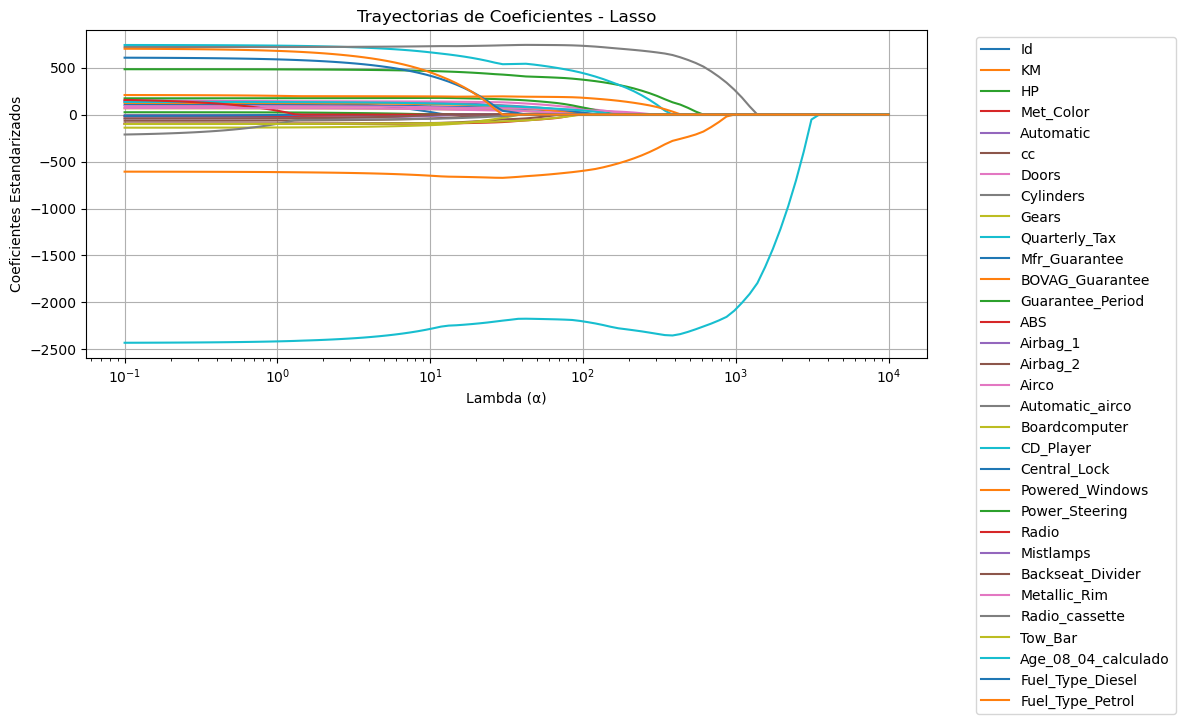

In [66]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

df_lasso = df.copy()

df_lasso = df_lasso.drop(columns=["Model", "Weight", "Sport_Model"])

# 1. Preprocesamiento
X = df_lasso
y = df_lasso["Price"]

X = X.drop(columns=["Price"])

# Preprocesamiento
X = pd.get_dummies(X, drop_first=True)           # One-hot encoding
X = X.apply(pd.to_numeric, errors='coerce')      # Forzar datos a numérico
y = pd.to_numeric(y, errors='coerce')            # Lo mismo para el target

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. Lista de valores de alpha (de mayor a menor penalización)
alphas = np.logspace(-1, 4, 100)  # de 0.01 a 100
coefs = []

# 3. Entrenar un modelo Lasso por cada alpha
for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_scaled, y)
    coefs.append(lasso.coef_)

# 4. Convertir a DataFrame para graficar
coefs = np.array(coefs)
features = X.columns

# 5. Graficar trayectorias de coeficientes
plt.figure(figsize=(12, 6))
for i in range(len(features)):
    plt.plot(alphas, coefs[:, i], label=features[i])

plt.xscale('log')
plt.xlabel("Lambda (α)")
plt.ylabel("Coeficientes Estandarizados")
plt.title("Trayectorias de Coeficientes - Lasso")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [67]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# 2. Escalar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42
)

# 4. Entrenar LassoCV con búsqueda de alpha óptimo
lasso_cv = LassoCV(cv=5, random_state=42, max_iter=10000)
lasso_cv.fit(X_train, y_train)

# 5. Predicciones
y_train_pred = lasso_cv.predict(X_train)
y_test_pred = lasso_cv.predict(X_test)

# 6. Evaluación
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print("Alpha óptimo encontrado:", lasso_cv.alpha_)
print("\n--- Entrenamiento ---")
print("MSE:", mse_train)
print("R²:", r2_train)

print("\n--- Test ---")
print("MSE:", mse_test)
print("R²:", r2_test)

# 7. Mostrar coeficientes seleccionados
coeficientes = pd.Series(lasso_cv.coef_, index=X.columns)
print("\nCoeficientes seleccionados (!= 0):")
print(coeficientes[coeficientes != 0])

Alpha óptimo encontrado: 19.48469586695981

--- Entrenamiento ---
MSE: 1462555.3141227693
R²: 0.8858513741626307

--- Test ---
MSE: 1502537.8497159374
R²: 0.892075663782059

Coeficientes seleccionados (!= 0):
KM                     -661.505447
HP                      421.638488
Automatic               127.975506
cc                      -11.198668
Doors                   141.227232
Gears                    60.330825
Quarterly_Tax           468.120827
Mfr_Guarantee            50.785587
BOVAG_Guarantee         104.486672
Guarantee_Period        159.237603
ABS                    -168.199563
Airbag_2                -12.728963
Airco                    98.077565
Automatic_airco         693.244413
Boardcomputer          -119.161561
CD_Player               117.973801
Powered_Windows         173.413427
Power_Steering            2.239490
Metallic_Rim             58.501659
Radio_cassette          -35.665020
Tow_Bar                 -74.479836
Age_08_04_calculado   -2290.736691
Fuel_Type_Diesel     

In [68]:
import mlflow
import joblib
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def run_lasso_with_mlflow_from_scaled(X_scaled, y, feature_names, run_name="lasso_cv_run"):
    # 1. Split
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.3, random_state=42
    )

    with mlflow.start_run(run_name=run_name):
        # 2. Modelo
        model = LassoCV(cv=5, random_state=42, max_iter=10000)
        model.fit(X_train, y_train)

        # 3. Predicciones
        y_pred = model.predict(X_test)

        # 4. Métricas
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Log parámetros y métricas
        mlflow.log_param("alpha", model.alpha_)
        mlflow.log_metric("mse", mse)
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("r2_score", r2)

        # 5. Coeficientes
        coef = pd.Series(model.coef_, index=feature_names)
        coef_nonzero = coef[coef != 0]

        os.makedirs("mlartifacts", exist_ok=True)
        coef_path = os.path.join("mlartifacts", "lasso_nonzero_coefs.csv")
        coef_nonzero.to_csv(coef_path)
        mlflow.log_artifact(coef_path)

        # Guardar modelo
        model_path = os.path.join("mlartifacts", "lasso_model.pkl")
        joblib.dump(model, model_path)
        mlflow.log_artifact(model_path)

        # Guardar nombres de features
        features_path = os.path.join("mlartifacts", "features.txt")
        with open(features_path, "w") as f:
            f.write("\n".join(feature_names))
        mlflow.log_artifact(features_path)

    print("Modelo LassoCV registrado con MLflow.")

In [69]:
run_lasso_with_mlflow_from_scaled(X_scaled, y, X.columns.tolist())

🏃 View run lasso_cv_run at: http://localhost:5000/#/experiments/315406277584116552/runs/d28cf9b180c4429184f0250a8a5dca25
🧪 View experiment at: http://localhost:5000/#/experiments/315406277584116552
Modelo LassoCV registrado con MLflow.


En base a los coeficientes obtenidos del modelo Lasso, podemos observar las variables más y menos relevantes para predecir el precio de los autos.
Ahora quitaremos las variables que tienen coeficientes entre -100 y 100, ya que estas son las que aportan menos información relevante al modelo.

In [70]:
coeficientes = pd.Series(lasso_cv.coef_, index=X.columns)
umbral = 100
casi_cero = coeficientes[np.abs(coeficientes) < umbral]

print("Features con coeficientes cercanos a cero:")
print(casi_cero.sort_values())


Features con coeficientes cercanos a cero:
Tow_Bar            -74.479836
Radio_cassette     -35.665020
Airbag_2           -12.728963
cc                 -11.198668
Cylinders            0.000000
Airbag_1             0.000000
Central_Lock         0.000000
Met_Color            0.000000
Backseat_Divider    -0.000000
Radio               -0.000000
Mistlamps           -0.000000
Id                  -0.000000
Power_Steering       2.239490
Mfr_Guarantee       50.785587
Metallic_Rim        58.501659
Gears               60.330825
Fuel_Type_Petrol    85.232779
Airco               98.077565
dtype: float64


In [71]:
# Eliminar features casi nulas del X original
X_filtrado = X.drop(columns=casi_cero.index)

# Escalar de nuevo
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled_filtrado = scaler.fit_transform(X_filtrado)

Luego de eliminar estas variables volvemos a ejecutar el modelo Lasso para reducir la cantidad de features y mejorar la interpretabilidad del modelo.

In [72]:
run_lasso_with_mlflow_from_scaled(X_scaled_filtrado, y, X_filtrado.columns.tolist())

🏃 View run lasso_cv_run at: http://localhost:5000/#/experiments/315406277584116552/runs/1dde06c52c214ec086858bdb9125d6ee
🧪 View experiment at: http://localhost:5000/#/experiments/315406277584116552
Modelo LassoCV registrado con MLflow.


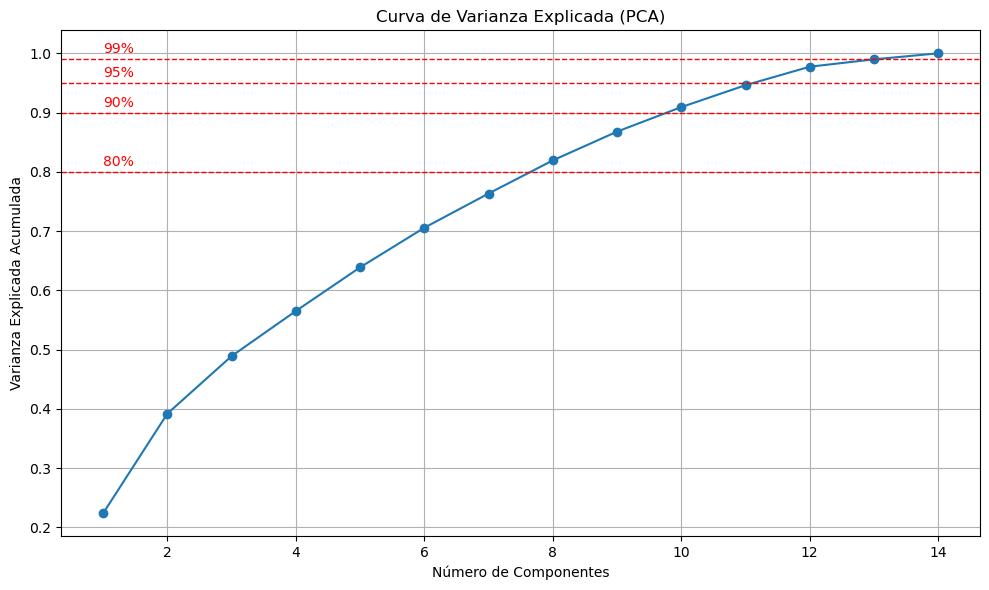

    Componente  Varianza Explicada  Acumulada
0            1            0.223893   0.223893
1            2            0.168126   0.392019
2            3            0.097065   0.489084
3            4            0.076078   0.565162
4            5            0.073663   0.638825
5            6            0.066835   0.705660
6            7            0.057761   0.763421
7            8            0.055929   0.819350
8            9            0.048527   0.867877
9           10            0.041373   0.909251
10          11            0.036986   0.946237
11          12            0.031190   0.977427
12          13            0.012436   0.989863
13          14            0.010137   1.000000


In [73]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 1. Normalizar los datos (PCA es sensible a la escala)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_filtrado)

# 2. Aplicar PCA (sin especificar componentes aún)
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# 3. Ver proporción de varianza explicada
explained_var_ratio = pca.explained_variance_ratio_
cumulative_var_ratio = np.cumsum(explained_var_ratio)

# 4. Graficar varianza explicada
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_var_ratio) + 1), cumulative_var_ratio, marker='o', label='Varianza Acumulada')
plt.xlabel("Número de Componentes")
plt.ylabel("Varianza Explicada Acumulada")
plt.title("Curva de Varianza Explicada (PCA)")
plt.grid(True)

# Líneas horizontales de referencia
for threshold in [0.80, 0.90, 0.95, 0.99]:
    plt.axhline(y=threshold, color='r', linestyle='--', linewidth=1)
    plt.text(1, threshold + 0.01, f"{int(threshold*100)}%", color='r')

plt.tight_layout()
plt.show()

varianza_por_componente = pd.DataFrame({
    "Componente": np.arange(1, len(explained_var_ratio)+1),
    "Varianza Explicada": explained_var_ratio,
    "Acumulada": cumulative_var_ratio
})

print(varianza_por_componente)

El análisis combinado de selección de variables mediante Lasso y reducción de dimensionalidad con PCA permitió identificar un conjunto de características representativas para predecir el precio. Lasso seleccionó las variables más relevantes, eliminando coeficientes cercanos a cero y simplificando el modelo. Posteriormente, el análisis de varianza acumulada del PCA mostró que con solo 8 componentes se explica más del 80% de la variabilidad total de los datos, confirmando que las variables seleccionadas capturan la mayor parte de la información importante.

Esto indica que la selección de características con Lasso es efectiva para reducir la complejidad sin perder información crítica, y que la aplicación de PCA puede complementar esta selección para entender la estructura de la variabilidad del conjunto de datos. En términos prácticos, se puede optar por usar directamente las variables seleccionadas por Lasso para mantener la interpretabilidad del modelo, o incorporar PCA para modelos que se benefician de una representación en menor dimensión.